In [55]:
import os
import graphviz
import time
import pickle
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time

# ML Scikit Imports
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# tensorflow imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

ANN_MODEL_CSV_FOLDER = os.path.join("./", "artificial_neural_network_stft/")
if not os.path.exists(ANN_MODEL_CSV_FOLDER):
    os.makedirs(ANN_MODEL_CSV_FOLDER)
ANN_MODEL_JSON = os.path.join(ANN_MODEL_CSV_FOLDER, "artificial_neural_network_stft.json")
ANN_MODEL_H5 = os.path.join(ANN_MODEL_CSV_FOLDER, "artificial_neural_network_stft.h5")
ANN_MODEL_H5_WEIGHTS = os.path.join(ANN_MODEL_CSV_FOLDER, "artificial_neural_network_stft_weights.h5")
ANN_MODEL_HISTORY = os.path.join(ANN_MODEL_CSV_FOLDER, "artificial_neural_network_stft_history.txt")

In [56]:
# Load compressed models from tensorflow_hub
import os
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# links with google drive and colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

if IN_COLAB:
   from google.colab import drive
   drive.mount('/content/gdrive')
   code_folder = '/content/gdrive/My Drive/Colab Notebooks/ENSTA/EML/training/artificial_neural_network'
   %cd "$code_folder"
   !ls "$code_folder"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/ENSTA/EML/training/artificial_neural_network
artificial_neural_network_mfcc	      artificial_neural_network_stft
artificial_neural_network_mfcc.ipynb  artificial_neural_network_stft.ipynb


### Extract the dataset from the .au csv files

In [57]:
print("Extracting dataset training set...")
dataset = '../../datasets/music_features_stft_train.csv'
musics_df = pd.read_csv(dataset, header=0)
# Get all style values
Y_train = musics_df["style"].values
# Get all features names
features_name = musics_df.columns.values[:-2]
# Get all features values
# musics_df = musics_df.drop('style', axis=1)
# musics_df = musics_df.drop('file_name', axis=1)
# X = musics_df.values
X_train = musics_df.loc[:, ~musics_df.columns.isin(['style', 'file_name'])].values
unique_label_names = np.unique(X_train)
input_shape = X_train.shape[1]

print("File contains {} unique_label_names: ".format(len(unique_label_names), unique_label_names))
print("File contains {} lines of {} data ".format(X_train.shape[0], X_train.shape[1]))

print("Extracting dataset testing set...")
dataset = '../../datasets/music_features_stft_test.csv'
musics_df = pd.read_csv(dataset, header=0)
# Get all style values
Y_test = musics_df["style"].values
# Get all features names
features_name = musics_df.columns.values[:-2]
# Get all features values
# musics_df = musics_df.drop('style', axis=1)
# musics_df = musics_df.drop('file_name', axis=1)
# X = musics_df.values
X_test = musics_df.loc[:, ~musics_df.columns.isin(['style', 'file_name'])].values
unique_label_names = np.unique(Y_test)

print("File contains {} unique_label_names: ".format(len(unique_label_names), unique_label_names))
print("File contains {} lines of {} data ".format(X_test.shape[0], X_test.shape[1]))

Extracting dataset training set...
File contains 333568 unique_label_names: 
File contains 799 lines of 512 data 
Extracting dataset testing set...
File contains 10 unique_label_names: 
File contains 201 lines of 512 data 


### Create the train, validation and test dataset for tensorflow

In [58]:
# Create Validation dataset
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, stratify=np.array(Y_train), random_state=42)

#Ttransform classes str to int
enc_str2int = preprocessing.LabelEncoder()
enc_str2int.fit(np.unique(Y_train))
Y_train = enc_str2int.transform(Y_train)
Y_test = enc_str2int.transform(Y_test)
Y_val = enc_str2int.transform(Y_val)

# Convert dataset into tf.data.Dataset
ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle 1000 times the training set and add batching & prefetching
batch_size = 16
dataset_size = X_train.shape[0]
train_set = ds_train.shuffle(1000).repeat()
train_set = train_set.batch(batch_size).prefetch(1)
valid_set = ds_val.batch(batch_size).prefetch(1)
test_set = ds_test.batch(batch_size).prefetch(1)

print("Train set format: ", train_set)
print("Test set format: ", test_set)
print("Validation set format :", valid_set)

Train set format:  <PrefetchDataset shapes: ((None, 512), (None,)), types: (tf.float64, tf.int64)>
Test set format:  <PrefetchDataset shapes: ((None, 512), (None,)), types: (tf.float64, tf.int64)>
Validation set format : <PrefetchDataset shapes: ((None, 512), (None,)), types: (tf.float64, tf.int64)>


# Artificial Neural Network

### Optimize model using cross validation

In [59]:
loss="sparse_categorical_crossentropy"
# optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

print("Creating Artificial Neural Network model...")
ann_model = Sequential()
ann_model.add(Dense(input_shape = (input_shape,), units=input_shape/3, activation="relu", name="dense_1"))
# output layer of size 1x1xn_classes
ann_model.add(Dense(units=len(unique_label_names), activation="softmax", name="output"))

print("Model summary: ")
ann_model.summary()


Creating Artificial Neural Network model...
Model summary: 
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 170)               87210     
                                                                 
 output (Dense)              (None, 10)                1710      
                                                                 
Total params: 88,920
Trainable params: 88,920
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Compile model
ann_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
# Use early stoping to stop the learning once the mode lperformances stop improving
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=500, verbose=1, mode='auto')
# model_cp = ModelCheckpoint(SVM_MODEL_H5_WEIGHTS, monitor='val_loss',  verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
# Save the best model observed during training for later use

best_val_acc = 0
best_val_loss = sys.float_info.max 

def save_model(epoch, logs):
    global best_val_acc, best_val_loss
    val_acc = logs['val_accuracy']
    val_loss = logs['val_loss']
    if val_acc > best_val_acc and (val_loss-best_val_loss<0.5)  :
        best_val_loss=val_loss
        print("\nvall acc improved from {} to {}, vall loss improved from {} to {}, saving model to best_model variable".format(best_val_acc, val_acc, best_val_loss, val_loss))
        best_val_acc = val_acc
        # Save model weights
        ann_model.save_weights(ANN_MODEL_H5_WEIGHTS)
        print("Model weights saved to disk")


In [61]:
# Learnign stage
t_start = time()
history = ann_model.fit(train_set,
                    validation_data=valid_set,
                    epochs=1000,
                    verbose=1,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks=[LambdaCallback(on_epoch_end=save_model), early_stop])
print("Training done in {}s".format(time()-t_start))

Epoch 1/1000
25/29 [========================>.....] - ETA: 0s - loss: 2.0387 - accuracy: 0.2875
vall acc improved from 0 to 0.4749999940395355, vall loss improved from 1.536068081855774 to 1.536068081855774, saving model to best_model variable
Model weights saved to disk
29/29 [==============================] - 1s 15ms/step - loss: 1.9911 - accuracy: 0.3017 - val_loss: 1.5361 - val_accuracy: 0.4750
Epoch 2/1000
29/29 [==============================] - 0s 3ms/step - loss: 1.4204 - accuracy: 0.5086 - val_loss: 1.4069 - val_accuracy: 0.4375
Epoch 3/1000
24/29 [=======================>......] - ETA: 0s - loss: 1.4225 - accuracy: 0.5078
vall acc improved from 0.4749999940395355 to 0.512499988079071, vall loss improved from 1.3637186288833618 to 1.3637186288833618, saving model to best_model variable
Model weights saved to disk
29/29 [==============================] - 0s 3ms/step - loss: 1.4307 - accuracy: 0.5108 - val_loss: 1.3637 - val_accuracy: 0.5125
Epoch 4/1000
26/29 [=================

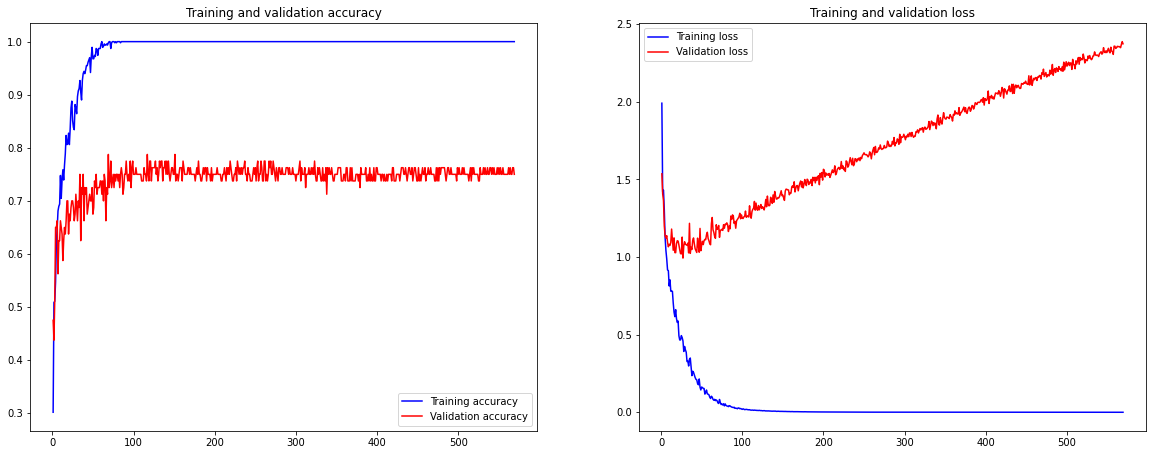

In [62]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(20,7.5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Create the final model using the best estimator found

Testing final Artificial Neural Network model...
              precision    recall  f1-score   support

       blues       0.76      0.62      0.68        21
   classical       0.82      0.90      0.86        20
     country       0.68      0.75      0.71        20
       disco       0.62      0.65      0.63        20
      hiphop       0.57      0.60      0.59        20
        jazz       0.88      0.75      0.81        20
       metal       0.83      0.95      0.88        20
         pop       0.78      0.70      0.74        20
      reggae       0.56      0.50      0.53        20
        rock       0.55      0.60      0.57        20

    accuracy                           0.70       201
   macro avg       0.70      0.70      0.70       201
weighted avg       0.70      0.70      0.70       201



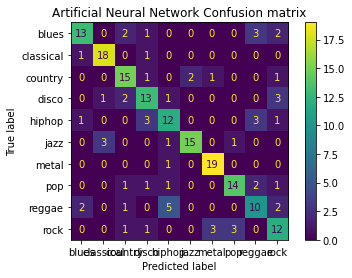

In [63]:
print("Testing final Artificial Neural Network model...")
ann_model.load_weights(ANN_MODEL_H5_WEIGHTS)
preds_valid = ann_model.predict(test_set)
preds_valid = np.argmax(preds_valid, axis=1)

# Metrics off the dataset
print(classification_report(Y_test, preds_valid, target_names=unique_label_names))
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(Y_test, preds_valid, display_labels=unique_label_names)
plt.title("Artificial Neural Network Confusion matrix")
plt.show()
# plot_confusion_matrix(y_test_index, preds_valid_id, classes=unique_label_names, title='Support Vector Machine Confusion matrix')

### Export model to csv file

In [64]:
 weights_and_biases = ann_model.get_weights()
 number_of_layers = len(weights_and_biases)/2

for i in range(0, len(weights_and_biases), 2):
  # Weights i
  # bias i+1
  CSV_HEADER = ["bias"] + list("weight{}".format(ni) for ni in range(len(weights_and_biases[i])))

  neuron_weights_and_biases = np.zeros((len(weights_and_biases[i+1]), len(weights_and_biases[i])+1))
  # print(neuron_weights_and_biases.shape)
  for bi in range(len(weights_and_biases[i+1])):
    neuron_weights_and_biases[bi, 0] = weights_and_biases[i+1][bi]
    for ni in range(len(weights_and_biases[i])):
      neuron_weights_and_biases[bi, ni+1] = weights_and_biases[i][ni, bi]

  # print(neuron_weights_and_biases[0])
  if i == len(weights_and_biases)/2 :
    ann_df = pd.DataFrame(neuron_weights_and_biases, columns=CSV_HEADER)
    ann_df["class"] = unique_label_names
    ann_df["class"] = ann_df["class"].astype(str)
    ann_df[CSV_HEADER[:]] = ann_df[CSV_HEADER[:]].astype(float)
  else:
    ann_df = pd.DataFrame(neuron_weights_and_biases, columns=CSV_HEADER)
    ann_df = ann_df.astype(float)

  csv_file = os.path.join(ANN_MODEL_CSV_FOLDER, "hidden_layer_{}.csv".format(int(i/2+1)))
  print("CSV file path: {}".format(csv_file))
  print("CSV file header: {}".format(CSV_HEADER))

  pd.DataFrame([CSV_HEADER]).to_csv(csv_file, mode='w', index=False, header=False, quoting=csv.QUOTE_NONE)
  ann_df.to_csv(csv_file, mode='a', index=False, header=False, quoting=csv.QUOTE_NONNUMERIC)


CSV file path: ./artificial_neural_network_stft/hidden_layer_1.csv
CSV file header: ['bias', 'weight0', 'weight1', 'weight2', 'weight3', 'weight4', 'weight5', 'weight6', 'weight7', 'weight8', 'weight9', 'weight10', 'weight11', 'weight12', 'weight13', 'weight14', 'weight15', 'weight16', 'weight17', 'weight18', 'weight19', 'weight20', 'weight21', 'weight22', 'weight23', 'weight24', 'weight25', 'weight26', 'weight27', 'weight28', 'weight29', 'weight30', 'weight31', 'weight32', 'weight33', 'weight34', 'weight35', 'weight36', 'weight37', 'weight38', 'weight39', 'weight40', 'weight41', 'weight42', 'weight43', 'weight44', 'weight45', 'weight46', 'weight47', 'weight48', 'weight49', 'weight50', 'weight51', 'weight52', 'weight53', 'weight54', 'weight55', 'weight56', 'weight57', 'weight58', 'weight59', 'weight60', 'weight61', 'weight62', 'weight63', 'weight64', 'weight65', 'weight66', 'weight67', 'weight68', 'weight69', 'weight70', 'weight71', 'weight72', 'weight73', 'weight74', 'weight75', 'weig

### Export model to h5 tensorflow file

In [65]:
# Save model description
model_json = ann_model.to_json()
with open(ANN_MODEL_JSON, "w") as json_file:
     json_file.write(model_json)
print("Model description saved to disk")

# Save model
ann_model.save(ANN_MODEL_H5)
print("Model saved to disk")

# Save model weights
ann_model.save_weights(ANN_MODEL_H5_WEIGHTS)
print("Model weights saved to disk")

# Fit history saving
with open(ANN_MODEL_HISTORY, 'wb') as file_pi:
     pickle.dump(history.history, file_pi)
print("Model history saved to disk")


Model description saved to disk
Model saved to disk
Model weights saved to disk
Model history saved to disk


### Cross validation to search for the best layer number and size 

In [ ]:
def build_ann_model(nfeatures, nlayer1, nlayer2, noutput, dropout): 
    model = keras.Sequential()
    model.add(Dense(input_shape=(nfeatures,), units=nlayer1, activation='relu', name="input"))
    model.add(Dropout(dropout, name="dropout_1"))
    if nlayer2 != 0:
      model.add(Dense(units=nlayer2, activation='relu', name="dense_1"))
      model.add(Dropout(dropout, name="dropout_2"))
    model.add(Dense(units=noutput, activation="softmax", name="output"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics= ['accuracy'])
    return model

# Use early stoping to stop the learning once the mode lperformances stop improving
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='auto')
# model_cp = ModelCheckpoint(SVM_MODEL_H5_WEIGHTS, monitor='val_loss',  verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
# Save the best model observed during training for later use

best_val_acc = 0
best_val_loss = sys.float_info.max 

def save_model(epoch, logs):
    global best_val_acc, best_val_loss
    val_acc = logs['val_accuracy']
    val_loss = logs['val_loss']
    if val_acc > best_val_acc and val_loss < best_val_loss :
        best_val_loss=val_loss
        print("vall acc improved from {} to {}, vall loss improved from {} to {}, saving model to best_model variable".format(best_val_acc, val_acc, best_val_loss, val_loss))
        best_val_acc = val_acc
        tmp_model.save_weights('tmp_'+ANN_MODEL_H5_WEIGHTS)
        print("Model weights saved to disk")

In [ ]:
from datetime import datetime

layer_1_list = list(range(int(input_shape/2), input_shape, 1))
layer_2_list = list(range(int(input_shape/4), input_shape, 10))
layer_2_list.append(0)

start_time = datetime.now()

# Hyperparameters tuning using cross-validation with grid search
print("Starting cross-validation hyperparameters tuning...")
model_scores = {}
model_index = 0
hyperparameters_size = len(layer_1_list)*len(layer_2_list)
progress = 0
print("======= {:0.2f}% ({}/{}) done =======".format(progress*100, progress*hyperparameters_size, hyperparameters_size))

for i in range(len(layer_1_list)):
    layer_1 = layer_1_list[i]
    for j in range(len(layer_2_list)):
        layer_2 = layer_2_list[j]
        model_index += 1
        score_sum = 0

        # Compile model
        tmp_model = build_ann_model(input_shape, layer_1, layer_2, input_shape, 0.2)
        # Use early stoping to stop the learning once the mode lperformances stop improving
        early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='auto')
        # model_cp = ModelCheckpoint(SVM_MODEL_H5_WEIGHTS, monitor='val_loss',  verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
        # Save the best model observed during training for later use

        global best_val_acc, best_val_loss
        best_val_acc = 0
        best_val_loss = sys.float_info.max 

        # Learnign stage
        history = tmp_model.fit(train_set,
                            validation_data=valid_set,
                            epochs=1000,
                            verbose=0,
                            steps_per_epoch=int(0.75 * dataset_size / batch_size),
                            validation_steps=int(0.15 * dataset_size / batch_size),
                            callbacks=[early_stop])
      
        progress = (i * len(layer_1_list) + j + 1) / (hyperparameters_size)
        model_scores["{}:{}".format(layer_1, layer_2)]= {'val_accuracy':best_val_acc,'val_loss': best_val_loss}
        print("--------- Results: (layer_1: {}, layer_2: {}, val_accuracy: {:0.2f}%,  val_loss: {:0.2f}%)".format(layer_1, layer_2, best_val_acc, best_val_loss))
        print("======= {:0.2f}% ({}/{}) done =======".format(progress*100, progress*hyperparameters_size, hyperparameters_size))

stop_time = datetime.now()
print("Elapsed time: {}".format(stop_time - start_time))

In [ ]:
biggest_acc = {'none':0}
smallest_loss = {'none':sys.float_info.max}
for k,v in model_scores.items():
  if v['val_accuracy'] >= list(biggest_acc.values())[0]:
    biggest_acc = {k:v['val_accuracy']}
  if v['val_loss'] >= list(smallest_loss.values())[0]:
    smallest_loss = {k:v['val_loss']}

print("best accuracy (layer1_layer2): {}".format(biggest_acc))
print("best loss (layer1_layer2): {}".format(smallest_loss))
  